# Ensemble Modeling Demonstration

In the previous notebook, we constructed a number of different models with the aim of predicting the average US domestic price for a non-organic avocado based on three years of historical data. In this notebook we will see how multiple models may be combined to generate predictions that outperform any one of the models on its own. 

A number of ensemble modeling methods are available to choose from, depending on the type of problem being solved. For the sake of discussion, here is a list of methods (non-exaustive, despite its lenght):

### Averaging Methods

<ul>
<li>Voting Ensembles</li>
<li>Weighted Voting</li>
<li>Averaging (and Geometric averaging)</li>
<li>Weighted Averaging</li>
<li>Ranked Averaging
</ul>

### Stacked Generalization Methods

Two categories:
<ul>
<li>Stacked Generalization</li>
<li>Blended models</li>
</ul>
depending on how you split up your data between test and train

Some specific stacking architectures:
<ul>
<li>Feature weighted linear stacking</li>
<li>Quadratic Linear Stacking</li>
<li>Stacking regressors with Classifiers</li>
<li>Stacking classifiers with regressors</li>
<li>Unsupervised learning model stacking</li>
</ul>

... and so on. <b>Feature weighted linear stacking</b> would be the most adaptive formulation of ensembling, and very appropriate for the JunEngine use case. In these scenarios, stacks engineered meta-features are combined together with model predictions. The hope is that the stacking model learns which base model is the best predictor for samples with a certain feature value. 

Let's attempt to contruct an ensemble wherein we take a weighted average of outputs of the L1 learners. 

In [637]:
## Library imports
import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# import lightgbm as lgb


import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from fbprophet import Prophet

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
import sklearn
sklearn.__version__

'0.19.0'

In [3]:
## Data preparation
raw_data = pd.read_csv("avocado.csv")
data = raw_data.loc[ ( raw_data['region']=='TotalUS' ) & ( raw_data['type']=='conventional' ) ].copy()[['Date', 'year', 'AveragePrice']]
data = data.assign( Date=pd.to_datetime(data.Date) )
data = data.assign( month=[x.month for x in data.Date])
data = data.assign( week=[x.isocalendar()[1] for x in data.Date])
# Weeks until 'Cinco dey Mayo'
data = data.assign( weeks_before_cdm=[ dt.datetime(r['year'], 5, 5).isocalendar()[1] - r['week'] for i, r in data.iterrows() ] )
data = data.sort_values(['year', 'week' ], ascending=[True, True])
data = data.reset_index(drop=True)

In [4]:
lagged_price = [ data['AveragePrice'].iloc[10-n:len(data)-n].values for n in np.arange(1,11) ] 
lags = [ 'price_lagged_' + str(n) for n in np.arange(1,11) ]
lagged_price_df = pd.DataFrame( { l:p for l, p in zip(lags,lagged_price) } )  
lagged_price_df = lagged_price_df.reset_index(drop=True)
data_chopped = data.iloc[10:].copy()
data_chopped = data_chopped.reset_index(drop=True)
merged_data = data_chopped.merge( lagged_price_df, left_index=True, right_index=True )
# merged_data = merged_data.drop(columns=['Date', 'Date'])

In [5]:
target = "AveragePrice"
X_features = [ c for c in merged_data.columns.values if ( target not in c and 'Date' not in c ) ]
X = merged_data[X_features].values
Y = merged_data[target].values.ravel()

## Class and method definitions for our models

To begin, we must split up our data set into train+test and hold-out subsamples. We will use the test+train sample to train the L1 learners, and the test and hold-out (or out-of-fold) sets to train and test the aggregator, respectively. 

In [9]:
n_samples_total = len(data)

In [10]:
i_oof_start = len(data)//2

In [11]:
X_L1 = merged_data.iloc[:i_oof_start][X_features].values
Y_L1 = merged_data.iloc[:i_oof_start]['AveragePrice'].values.ravel()
X_oof = merged_data.iloc[i_oof_start:][X_features].values
Y_oof = merged_data.iloc[i_oof_start:]['AveragePrice'].values.ravel()


In [12]:
class TrainingResult():
    def __init__(self, metrics=["MSE"]):
        self.model_names = []
        self.metrics = metrics
        self.units = None
        self.scores = { sn : [] for sn in self.metrics } 
        self.df = None
        self.display_mode = 'str'
        
    def add_result(self, model_name, scores ):
        for k, v in scores.items():
            try: 
                self.scores[k].append(v)
            except Exception as err:
                print(f"Could not add score: {k}:{v}: {err}")
        self.model_names.append(model_name)
        
    def get_df(self): 
        cols = [ 'Model' ] + self.metrics
        data = { c : [] for c in cols }
        data['Model'] = self.model_names
       
        for m in self.metrics:
            if self.display_mode == 'str':
                data[m] = list(map(lambda x: str(round(x[0], 3)) + " \xb1 " + str(round(x[1],3)), self.scores[m] ))
            else:
                data[m] = self.scores[m]
        df = pd.DataFrame.from_dict( data )
        return df

In [13]:

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        """Class for a simple averaging ensemble."""
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [14]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        """Class for a Stacked-average Ensemble."""
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = TimeSeriesSplit(n_splits=self.n_folds)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Do the predictions of all base models on the test data and use the averaged 
    # predictions as meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [15]:
# Prints the model score to the screen 
def print_result(name, rmse_rf, score_type='MSE'):
    print( f"{name} {score_type} Score: {round(np.mean(rmse_rf), 3)} +/- {round(np.std(rmse_rf),3)} ({[round(r, 3) for r in rmse_rf ]})")

In [16]:
#Validation function for Base Learners 
def rmsle_cv(model, train_X, train_Y, scoring='neg_mean_squared_error', n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse= np.sqrt(-cross_val_score(model, train_X, train_Y, scoring=scoring, cv = tscv))
    if scoring=='neg_mean_absolute_error' and np.mean(train_Y) != 0:
        rmse = 100 * rmse / np.mean(train_Y)
    return(rmse)

In [604]:
# New version of cross-validation routine, to handling things more explicitly
# so we can look at the fits
class TSCrossValidationHandler():
    def __init__(self, model, name, n_splits=3):
        """Class for handling time-series model cross-validation explicitly.
        
        This is needed in order to view the model fit results for each of the folds
        and to extract the model predictions for use as training features for an 
        ensemble model.        
        """
        self.model = model
        self.name = name
        self.n_splits = n_splits
        self.test_X = []
        self.test_resid_Y = []
        self.test_true_Y = []
        self.test_pred_Y = []
        self.train_X = []
        self.train_true_Y = []
        self.train_resid_Y = []
        self.train_pred_Y = []
        self.mses = []
        self.mapes = []
        self.figsize = (14, 9)

    def do_cross_val(self, X, Y):
        ## Do a log transform on Y
        tscv = TimeSeriesSplit(n_splits=self.n_splits) 
        i = 1
        for i_train, i_test in tscv.split(X):
            self.model.fit(X[i_train], Y[i_train])
            
            self.train_resid_Y.append([y-y_true for y_true,y in zip( Y[i_train], self.model.predict(X[i_train]))])
            self.train_true_Y.append(Y[i_train]) 
            self.train_X.append(i_train)
            self.train_pred_Y.append([y for y in self.model.predict(X[i_train])])
            self.test_resid_Y.append([y-y_true for y,y_true in zip(self.model.predict(X[i_test]), Y[i_test])])
            self.test_true_Y.append(Y[i_test])
            self.test_X.append(i_test)
            self.test_pred_Y.append([y for y in self.model.predict(X[i_test])])
                                      
            self.mses.append(mean_squared_error(Y[i_test], self.model.predict(X[i_test])))
           
            self.mapes.append( 100*np.mean( [ (y-Y[i])/Y[i] for i, y in zip(i_test, self.model.predict(X[i_test]))  ] ) )
                

            print(f"Fold {i} complete with: {len(i_train)} training samples and {len(i_test)} test samples.")
            i += 1
    
    def report_metrics(self):
        mse_mean = round(np.sqrt(np.mean(self.mses)),3)
        mse_std = round(np.sqrt(np.std(self.mses)),3)
        mape_mean = round(np.mean(self.mapes),3)
        mape_std = round(np.std(self.mapes),3)
        print(f"Cross-validation results for {self.name}:")
        print(f"   RMSE:   {mse_mean} \xb1 {mse_std}")
        print(f"   MAPE: ({mape_std} +/- {mape_std})%")
        print(f"   N Splits: {self.n_splits}\n")
        
    
    def plot_fits(self):
        """Plot the results of cross validation.
        
        Returns:
        ax -- An axis object containing the resultant plot
        
        """
        X_all_test = np.array(self.test_X).flatten()
        Y_all_test = np.array(self.test_true_Y).flatten()
        Y_all_test_pred = np.array(self.test_pred_Y).flatten()
        Y_resid_all_test = np.array(self.test_resid_Y).flatten()
        X_all_train = np.array(self.train_X).flatten()
        Y_all_train = np.array(self.train_true_Y).flatten()
        Y_all_fit = np.array(self.train_pred_Y).flatten()
        Y_all_fit_resid = np.array(self.train_resid_Y).flatten()
            
        # Plot the real data vs. the model 
        fig = plt.figure(figsize=self.figsize)
        fig.suptitle(f"Cross-validation Results for {self.name}", fontsize=16)
        plt.subplot(311)
        plt.title("Model Cross-validation Predicted Y vs. Y")
        ax1 = plt.plot(X_all_test, Y_all_test, marker='o', color='black', label="True Y")
        ax1 = plt.plot(X_all_test, Y_all_test_pred, marker='o', color='blue', label="Predicted Y" )
        
        plt.subplot(312)
        plt.title("Model Cross-validation Y-Errors")
        ax2 = plt.plot(X_all_test, Y_resid_all_test, marker='o', color='blue')
        sqrtmse = np.sqrt(np.mean(self.mses))
        ax2 = plt.plot([ X_all_test[0], X_all_test[-1]], [-sqrtmse, -sqrtmse], 'r--')
        ax2 = plt.plot([ X_all_test[0], X_all_test[-1]], [ sqrtmse,  sqrtmse], 'r--')
        
        
        plt.subplot(313)
        plt.title("Model Fit residuals (Final Training Split)")
        ax3 = plt.plot(X_all_train[-1], Y_all_fit_resid[-1], marker='o', color='green')
        
        plt.show()
        
        return fig
        
    

# Train and evaluate the Base Learners

In [620]:
handlers = []

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Random Forrest:
   RMSE:   0.123 ± 0.081
   MAPE: (9.993 +/- 9.993)%
   N Splits: 3



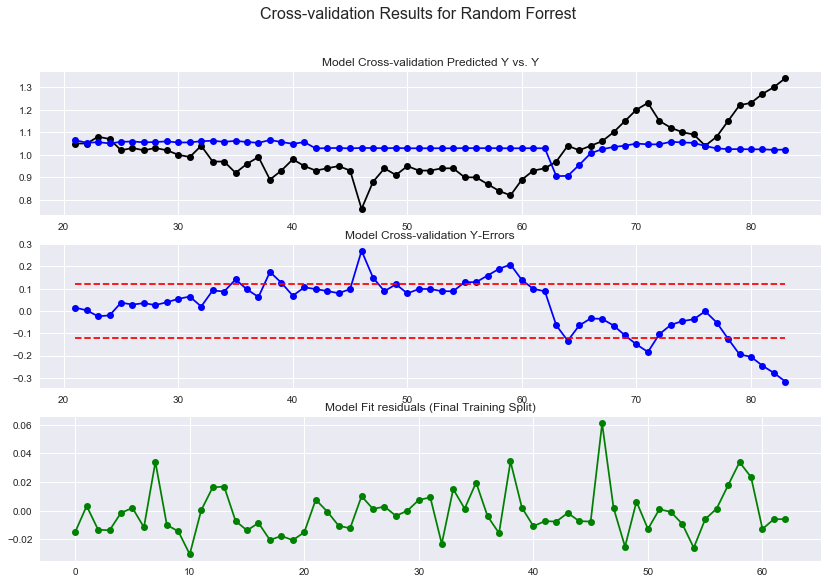

In [621]:
# Random forrest
clf_rfn = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1, n_estimators=300))
handlers.append(TSCrossValidationHandler(clf_rfn, "Random Forrest", n_splits=3))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for XGBoost:
   RMSE:   0.115 ± 0.08
   MAPE: (8.788 +/- 8.788)%
   N Splits: 3



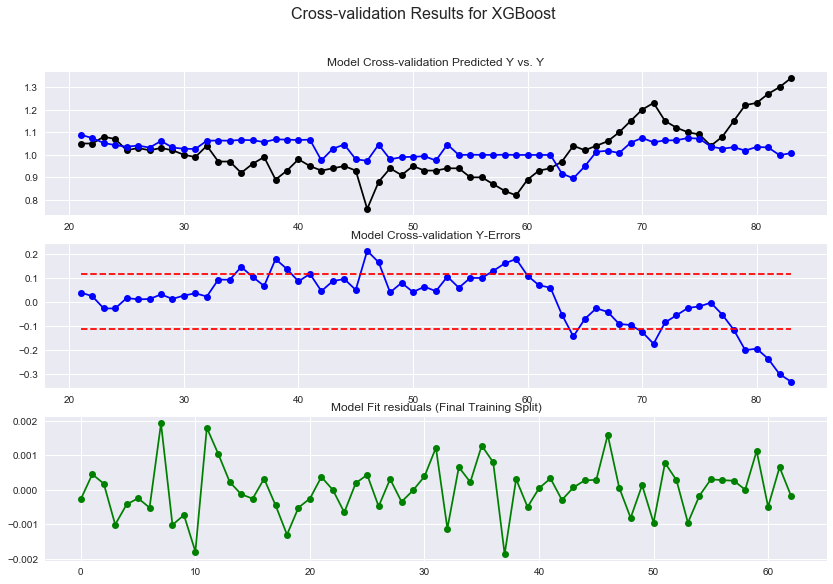

In [624]:
# XGBoost
clf_xgb = make_pipeline(StandardScaler(), XGBRegressor(n_estimators=1000, learning_rate=0.5, early_stopping_rounds=5))
handlers.append(TSCrossValidationHandler(clf_xgb, "XGBoost", n_splits=3))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Lasso:
   RMSE:   0.117 ± 0.08
   MAPE: (9.036 +/- 9.036)%
   N Splits: 3



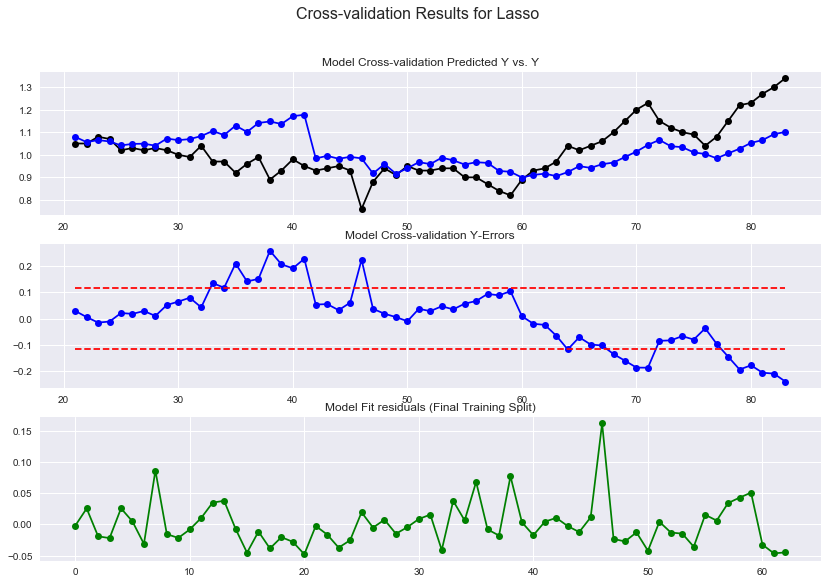

In [634]:
# Lasso regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
handlers.append(TSCrossValidationHandler(lasso, "Lasso", n_splits=3))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Elastic Net:
   RMSE:   0.118 ± 0.081
   MAPE: (9.16 +/- 9.16)%
   N Splits: 3



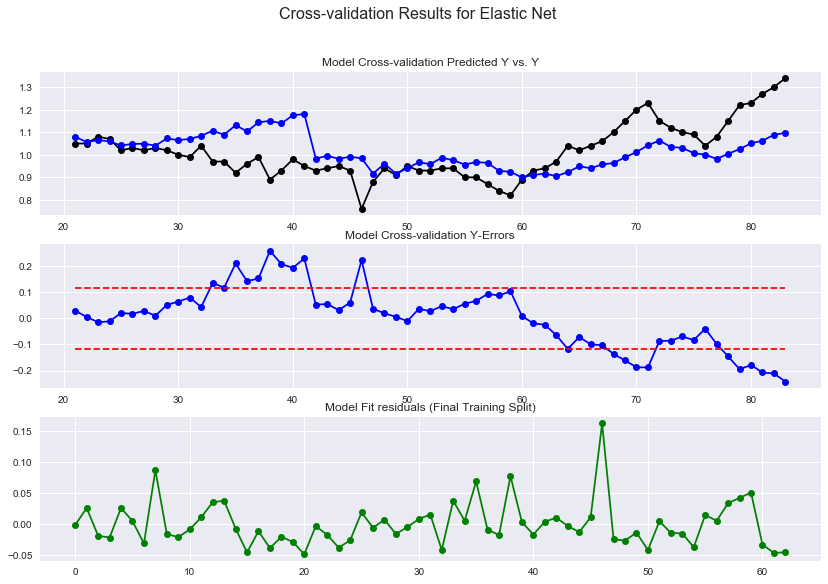

In [635]:
# Elastic Net Regression :again made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
handlers.append(TSCrossValidationHandler(ENet, "Elastic Net", n_splits=3))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

Fold 1 complete with: 21 training samples and 21 test samples.
Fold 2 complete with: 42 training samples and 21 test samples.
Fold 3 complete with: 63 training samples and 21 test samples.
Cross-validation results for Kernel Ridge Regression (deg 3):
   RMSE:   0.33 ± 0.342
   MAPE: (23.368 +/- 23.368)%
   N Splits: 3



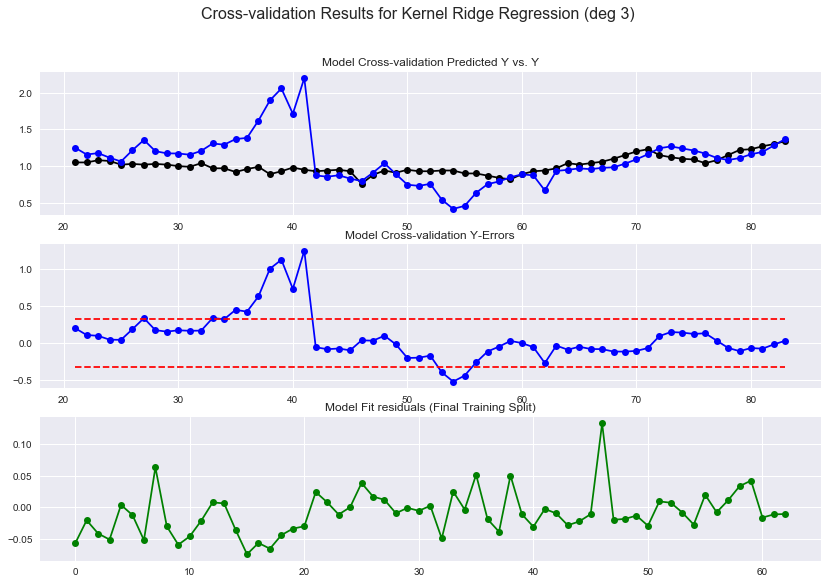

In [636]:
# Kernel Ridge Regression :
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR3 = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=3))
handlers.append(TSCrossValidationHandler(KRR3, "Kernel Ridge Regression (deg 3)", n_splits=3))
handlers[-1].do_cross_val(X_L1, Y_L1)
handlers[-1].report_metrics()
fig_rf = handlers[-1].plot_fits()

In [ ]:
# Kernel Ridge Regression :
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR2 = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2))
krr_rmse2 = rmsle_cv( KRR2, X_L1, Y_L1)
print_result("KRR2", krr_rmse2)
krr_mape2 = rmsle_cv( KRR2, X_L1, Y_L1, scoring='neg_mean_absolute_error')
print_result( "KRR2", krr_mape2, "MAPE" )
cv_result_table.add_result( "KRR (poly/deg 2)", {'MSE':ave_std(krr_rmse2), 'MAPE':ave_std(krr_mape2)} )
KRR2 = KRR2.fit(X_L1, Y_L1)
pipelines.append({"KRR2":KRR2})

## Base Model Selection

In [310]:
## Let's look at the fit errors and how they correlate between models
y_fits = [ h.test_pred_Y for h in handlers ]
y_resid = [ h.test_resid_Y for h in handlers ]
m_names = [ h.name for h in handlers ]
pipelines = [ h.model for h in handlers ]
        self.test_X = []
        self.test_resid_Y = []
        self.test_true_Y = []
        self.test_pred_Y = []

In [311]:
y_df = pd.DataFrame( data=merged_data.iloc[:i_oof_start]['AveragePrice'] )

In [312]:
# y_df = pd.DataFrame( data=merged_data.iloc[:i_oof_start]['AveragePrice'], columns='AveragePrice')

In [313]:
tr_resid_df = pd.DataFrame.from_dict( { m : r for m, r in zip(m_names, y_resid) })
#resid_df["X"] = list(X_L1)

In [314]:
tr_fit_df = pd.DataFrame.from_dict( { m : f for m, f in zip(m_names, y_fits) } )
#fit_df["X"] = list(X_L1)

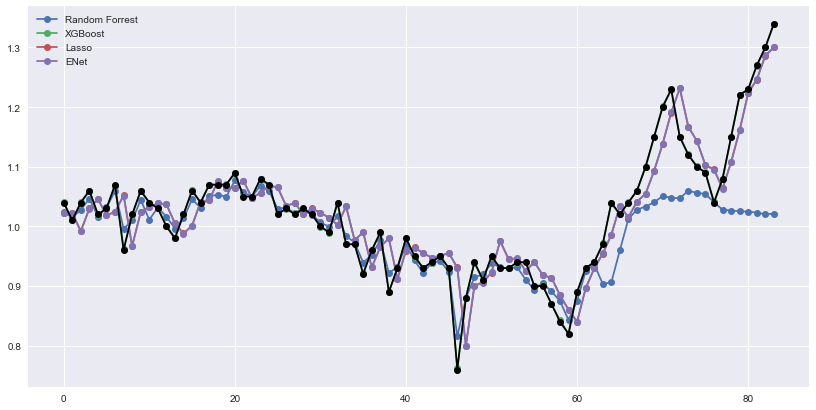

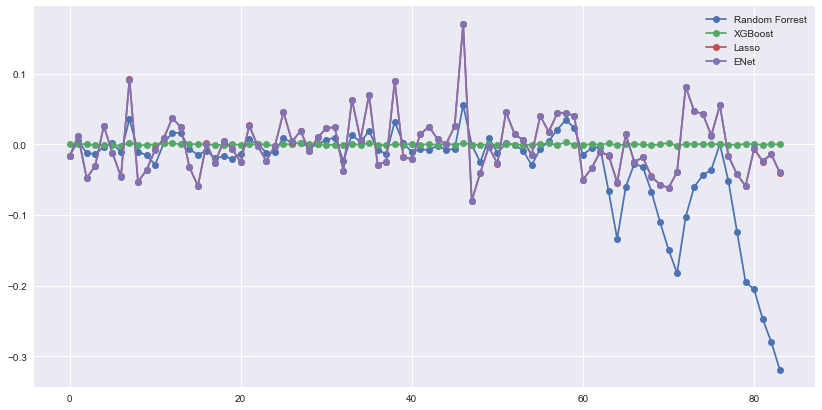

In [315]:
f_ax = tr_fit_df.plot(figsize=(14,7), marker='o')
f_ax = plt.plot(y_df.index, y_df['AveragePrice'], marker='o', color='black')
r_ax = tr_resid_df.plot(figsize=(14,7), marker='o')



In [319]:
y_pred_oof = []
y_pred_oof_resids = []
for p in pipelines:
    m_name = list(p)[0]
    m = p[m_name]
    y_pred_oof.append( m.predict(X_oof) )
    y_pred_oof_resids.append( [ yf - y for yf, y in zip(y_fits[-1], Y_oof) ] )
    m_names.append(m_name)

In [320]:
y_oof_df = pd.DataFrame( data=merged_data.iloc[i_oof_start:]['AveragePrice'] )
y_oof_df = y_oof_df.reset_index(drop=True)

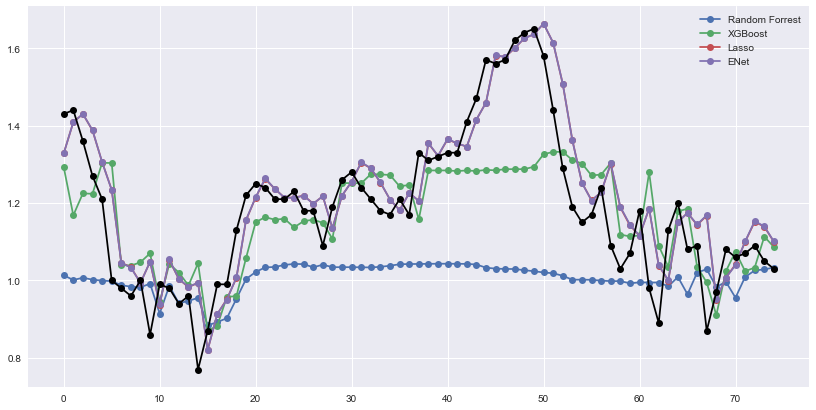

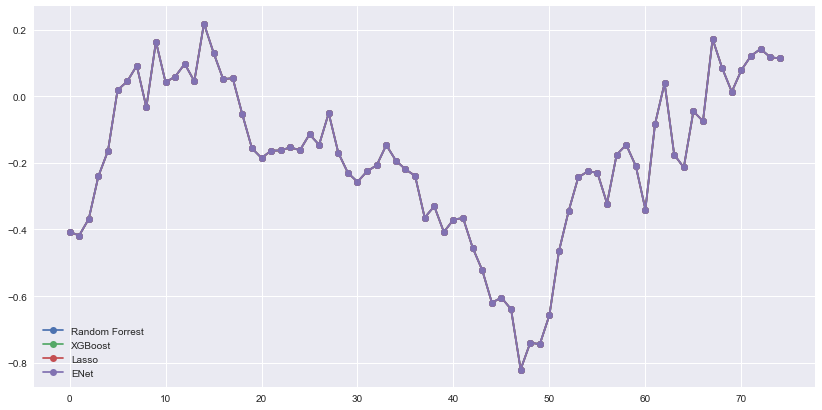

In [321]:
oof_resid_df = pd.DataFrame.from_dict( { m : r for m, r in zip(m_names, y_pred_oof_resids) })
#resid_df["X"] = list(X_L1)

oof_fit_df = pd.DataFrame.from_dict( { m : f for m, f in zip(m_names, y_pred_oof) } )
#fit_df["X"] = list(X_L1)

foof_ax = oof_fit_df.plot(figsize=(14,7), marker='o')
foof_ax = plt.plot(y_oof_df.index, y_oof_df['AveragePrice'], marker='o', color='black')
roof_ax = oof_resid_df.plot(figsize=(14,7), marker='o')



In [322]:
mse_table = { m : mean_squared_error(Y_oof, f) for m, f in zip(m_names, y_pred_oof) }

In [323]:
mse_table

{'ENet': 0.0097962112460778187,
 'Lasso': 0.0097549881454867485,
 'Random Forrest': 0.065008450488888814,
 'XGBoost': 0.020780828938611842}

In [324]:
mape_table = { m : mean_absolute_error(Y_oof, f) for m, f in zip(m_names, y_pred_oof) }

In [325]:
mape_table

{'ENet': 0.076302287035441438,
 'Lasso': 0.076040502033320398,
 'Random Forrest': 0.19736711111111102,
 'XGBoost': 0.11100186891555787}

AttributeError: Unknown property x

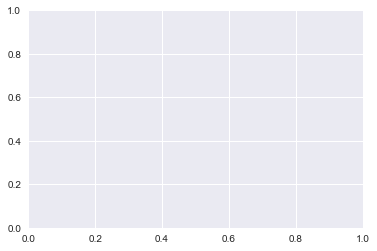

In [326]:
resid_df.plot(X='X')

In [ ]:
colormap = plt.cm.binary
plt.figure(figsize=(9,8))
plt.title('Pearson Correlation of Model Fit Residuals', y=1.05, size=15)
ax = sns.heatmap(resid_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Based on the plot above, it looks like XGBoost is the model having the least correlation of its residuals with the other models. Meanwhile, ENet and Lasso Regressors have highly correlated residuals. The random forrest and Kernel Ridge regressors shows moderate to moderatel-high correlations with all other model's residuals. 

Based on these residual correlations and the predictor performance, we choose to eliminate ENet and KRR(3) from our population of Base Learners. 

## Stacked Model with Meta Learner

Note: Non-linear algorithms find useful interactions between the original features and the meta-model features.

In [ ]:
meta_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (clf_rfn, clf_xgb, lasso, KRR2),
                                                 meta_model = meta_lasso)

In [ ]:
stacked_rmse = rmsle_cv( meta_lasso, X_L1, Y_L1)
print_result("Stacked", stacked_rmse)
stacked_mape = rmsle_cv( meta_lasso, X_L1, Y_L1, scoring='neg_mean_absolute_error')
print_result( "Stacked", stacked_mape, "MAPE" )
cv_result_table.add_result( "Stacked", {'MSE':ave_std(stacked_rmse), 'MAPE':ave_std(stacked_mape)} )

In [ ]:

y_pred_stacked = meta_lasso.predict(X_oof)
y_resid_stacked = [ yp - y for yp, y in zip(y_pred_stacked, Y_oof)] 

In [ ]:
scaore = rmsle_cv( stacked_averaged_models, X_L1, Y_L1 )

In [ ]:

print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_selection = [ (lasso, lasso_rmse_rf), 
                    (clf_xgb, rmse_xgb),
                    (clf_rfn, rmse_rf) ]

In [ ]:
total_rmse = np.sum([ np.mean(a[1]) for a in model_selection ])

In [ ]:
total_rmse

In [ ]:
weights = [ total_rmse/m for m in [ np.mean(a[1]) for a in model_selection  ] ]

In [ ]:
weights

In [ ]:
# Now train the models on all of the training data

In [ ]:
clf_rfn.fit?

## Ensemble Prediction

In [327]:
y_train
y_pred = []
for m in model_selection:

SyntaxError: unexpected EOF while parsing (<ipython-input-327-bc8bc0c77fa5>, line 3)